In [1]:
import pandas as pd
import math as m
from scipy import stats
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import  metrics
from itertools import product
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/vladimir/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/vladimir/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers
from keras.layers import LSTM, SpatialDropout1D
import keras

/home/vladimir/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
data = pd.read_csv("cleaned_unemployment.csv", index_col=['Unnamed: 0'])
GDP = pd.read_csv("cleaned_GDP.csv", index_col=['Unnamed: 0'])
data = pd.concat([data , GDP], axis = 1)
np.random.seed(42)

In [5]:
def time_series_to_DataFrame(data, lags, target):
    lags = list(map(lambda x: x+1, lags))
    #Готовим название колонок
    columns = []
    for i in range(len(data.columns)):
        #print (i , lags[i])
        for j in range(1, lags[i]):
            #print ('i = ', i,'j = ',j)
            #print (columns)
            columns.append(data.columns[i] + '_lag_' + str(j))
    columns.append(target)
    #готовим target
    target = pd.DataFrame(data[target].values[max(lags)-1:])
    #готовим индексы
    index = data.index
    
    
    data = data.values
    
    new_data = []
    for i in range(max(lags)-1,len(data)):
        res = []
        for lag in range(len(lags)):
            for j in range(1,lags[lag]):
                res.append(data[i-j][lag])
        new_data.append(res)
    
    
    new_data = pd.DataFrame(new_data)
    new_data = pd.concat([new_data, target], axis = 1)
    new_data.columns = columns
    new_data.index = index[max(lags)-1:]
    return new_data 

In [6]:
#лаги
lags = [5,3]
lag_data = time_series_to_DataFrame(data, lags, 'unemployment_cyclicity')

x_train = lag_data[lag_data.columns[:-1]].iloc[:-20]
x_val = lag_data[lag_data.columns[:-1]].iloc[-20:-12]
x_test = lag_data[lag_data.columns[:-1]].iloc[-12:]

y_train = lag_data[lag_data.columns[-1]].iloc[:-20]
y_val = lag_data[lag_data.columns[-1]].iloc[-20:-12]
y_test = lag_data[lag_data.columns[-1]].iloc[-12:]

In [9]:
x_test.head()

,unemployment_cyclicity_lag_1,unemployment_cyclicity_lag_2,unemployment_cyclicity_lag_3,unemployment_cyclicity_lag_4,unemployment_cyclicity_lag_5,GDP_cyclicity_lag_1,GDP_cyclicity_lag_2,GDP_cyclicity_lag_3
2014.25,-0.048167,-0.039545,-0.039611,-0.055057,-0.078589,0.017511,0.016362,0.016110
2014.50,-0.057857,-0.048167,-0.039545,-0.039611,-0.055057,0.017804,0.017511,0.016362
2014.75,-0.058753,-0.057857,-0.048167,-0.039545,-0.039611,0.014936,0.017804,0.017511
2015.00,-0.039524,-0.058753,-0.057857,-0.048167,-0.039545,0.007688,0.014936,0.017804
2015.25,-0.011284,-0.039524,-0.058753,-0.057857,-0.048167,-0.000313,0.007688,0.014936


In [112]:
%%time
np.random.seed(42)
neurons_1 = range(5, 10)
neurons_2 = range(5, 10)
epochs = 100

model = []
history = []
for i in range(len(neurons_1)):
    model.append([])
    history.append([])
    for j in range(len(neurons_2)):
        print (neurons_1[i], neurons_2[j])
        model[i].append(Sequential())
        filepath="model/weights_"+str(neurons_1[i])+'_'+str(neurons_2[j])+".hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
        model[i][j].add(Dense(neurons_1[i], activation='relu', input_shape=(x_train.shape[1],), ))
        model[i][j].add(Dropout(0.05))
        model[i][j].add(Dense(neurons_2[j], activation='relu', ))
        model[i][j].add(Dense(1))
        adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model[i][j].compile(optimizer=adam, loss='mae', metrics=['mae'])
        history[i].append(model[i][j].fit(x_train, y_train, epochs=epochs, batch_size=1,
                                   verbose=2, validation_data=(x_val, y_val),callbacks = [checkpoint] ))
        

5 5
Train on 62 samples, validate on 8 samples
Epoch 1/100
 - 3s - loss: 0.0771 - mean_absolute_error: 0.0771 - val_loss: 0.0723 - val_mean_absolute_error: 0.0723

Epoch 00001: val_loss improved from inf to 0.07230, saving model to model/weights_5_5.hdf5
Epoch 2/100
 - 1s - loss: 0.0665 - mean_absolute_error: 0.0665 - val_loss: 0.0641 - val_mean_absolute_error: 0.0641

Epoch 00002: val_loss improved from 0.07230 to 0.06409, saving model to model/weights_5_5.hdf5
Epoch 3/100
 - 1s - loss: 0.0620 - mean_absolute_error: 0.0620 - val_loss: 0.0661 - val_mean_absolute_error: 0.0661

Epoch 00003: val_loss did not improve
Epoch 4/100
 - 1s - loss: 0.0577 - mean_absolute_error: 0.0577 - val_loss: 0.0612 - val_mean_absolute_error: 0.0612

Epoch 00004: val_loss improved from 0.06409 to 0.06116, saving model to model/weights_5_5.hdf5
Epoch 5/100
 - 1s - loss: 0.0571 - mean_absolute_error: 0.0571 - val_loss: 0.0597 - val_mean_absolute_error: 0.0597

Epoch 00005: val_loss improved from 0.06116 to 0.

 - 0s - loss: 0.0173 - mean_absolute_error: 0.0173 - val_loss: 0.0131 - val_mean_absolute_error: 0.0131

Epoch 00048: val_loss did not improve
Epoch 49/100
 - 1s - loss: 0.0174 - mean_absolute_error: 0.0174 - val_loss: 0.0134 - val_mean_absolute_error: 0.0134

Epoch 00049: val_loss did not improve
Epoch 50/100
 - 0s - loss: 0.0187 - mean_absolute_error: 0.0187 - val_loss: 0.0124 - val_mean_absolute_error: 0.0124

Epoch 00050: val_loss did not improve
Epoch 51/100
 - 0s - loss: 0.0181 - mean_absolute_error: 0.0181 - val_loss: 0.0121 - val_mean_absolute_error: 0.0121

Epoch 00051: val_loss did not improve
Epoch 52/100
 - 1s - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0141 - val_mean_absolute_error: 0.0141

Epoch 00052: val_loss did not improve
Epoch 53/100
 - 0s - loss: 0.0191 - mean_absolute_error: 0.0191 - val_loss: 0.0121 - val_mean_absolute_error: 0.0121

Epoch 00053: val_loss did not improve
Epoch 54/100
 - 0s - loss: 0.0229 - mean_absolute_error: 0.0229 - val_loss: 0


Epoch 00100: val_loss did not improve
5 6
Train on 62 samples, validate on 8 samples
Epoch 1/100
 - 3s - loss: 0.0654 - mean_absolute_error: 0.0654 - val_loss: 0.0662 - val_mean_absolute_error: 0.0662

Epoch 00001: val_loss improved from inf to 0.06621, saving model to model/weights_5_6.hdf5
Epoch 2/100
 - 1s - loss: 0.0610 - mean_absolute_error: 0.0610 - val_loss: 0.0522 - val_mean_absolute_error: 0.0522

Epoch 00002: val_loss improved from 0.06621 to 0.05223, saving model to model/weights_5_6.hdf5
Epoch 3/100
 - 0s - loss: 0.0553 - mean_absolute_error: 0.0553 - val_loss: 0.0455 - val_mean_absolute_error: 0.0455

Epoch 00003: val_loss improved from 0.05223 to 0.04550, saving model to model/weights_5_6.hdf5
Epoch 4/100
 - 1s - loss: 0.0505 - mean_absolute_error: 0.0505 - val_loss: 0.0417 - val_mean_absolute_error: 0.0417

Epoch 00004: val_loss improved from 0.04550 to 0.04174, saving model to model/weights_5_6.hdf5
Epoch 5/100
 - 1s - loss: 0.0432 - mean_absolute_error: 0.0432 - val_l


Epoch 00047: val_loss did not improve
Epoch 48/100
 - 1s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0154 - val_mean_absolute_error: 0.0154

Epoch 00048: val_loss did not improve
Epoch 49/100
 - 1s - loss: 0.0157 - mean_absolute_error: 0.0157 - val_loss: 0.0153 - val_mean_absolute_error: 0.0153

Epoch 00049: val_loss did not improve
Epoch 50/100
 - 0s - loss: 0.0137 - mean_absolute_error: 0.0137 - val_loss: 0.0173 - val_mean_absolute_error: 0.0173

Epoch 00050: val_loss did not improve
Epoch 51/100
 - 0s - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0188 - val_mean_absolute_error: 0.0188

Epoch 00051: val_loss did not improve
Epoch 52/100
 - 1s - loss: 0.0163 - mean_absolute_error: 0.0163 - val_loss: 0.0154 - val_mean_absolute_error: 0.0154

Epoch 00052: val_loss did not improve
Epoch 53/100
 - 1s - loss: 0.0134 - mean_absolute_error: 0.0134 - val_loss: 0.0147 - val_mean_absolute_error: 0.0147

Epoch 00053: val_loss did not improve
Epoch 54/100
 - 0s - loss


Epoch 00097: val_loss did not improve
Epoch 98/100
 - 0s - loss: 0.0139 - mean_absolute_error: 0.0139 - val_loss: 0.0133 - val_mean_absolute_error: 0.0133

Epoch 00098: val_loss did not improve
Epoch 99/100
 - 0s - loss: 0.0134 - mean_absolute_error: 0.0134 - val_loss: 0.0124 - val_mean_absolute_error: 0.0124

Epoch 00099: val_loss did not improve
Epoch 100/100
 - 1s - loss: 0.0153 - mean_absolute_error: 0.0153 - val_loss: 0.0126 - val_mean_absolute_error: 0.0126

Epoch 00100: val_loss did not improve
5 7
Train on 62 samples, validate on 8 samples
Epoch 1/100
 - 2s - loss: 0.0586 - mean_absolute_error: 0.0586 - val_loss: 0.0673 - val_mean_absolute_error: 0.0673

Epoch 00001: val_loss improved from inf to 0.06733, saving model to model/weights_5_7.hdf5
Epoch 2/100
 - 0s - loss: 0.0546 - mean_absolute_error: 0.0546 - val_loss: 0.0732 - val_mean_absolute_error: 0.0732

Epoch 00002: val_loss did not improve
Epoch 3/100
 - 0s - loss: 0.0554 - mean_absolute_error: 0.0554 - val_loss: 0.0570 

 - 1s - loss: 0.0190 - mean_absolute_error: 0.0190 - val_loss: 0.0167 - val_mean_absolute_error: 0.0167

Epoch 00045: val_loss did not improve
Epoch 46/100
 - 1s - loss: 0.0167 - mean_absolute_error: 0.0167 - val_loss: 0.0148 - val_mean_absolute_error: 0.0148

Epoch 00046: val_loss did not improve
Epoch 47/100
 - 1s - loss: 0.0153 - mean_absolute_error: 0.0153 - val_loss: 0.0155 - val_mean_absolute_error: 0.0155

Epoch 00047: val_loss did not improve
Epoch 48/100
 - 1s - loss: 0.0137 - mean_absolute_error: 0.0137 - val_loss: 0.0152 - val_mean_absolute_error: 0.0152

Epoch 00048: val_loss did not improve
Epoch 49/100
 - 0s - loss: 0.0181 - mean_absolute_error: 0.0181 - val_loss: 0.0141 - val_mean_absolute_error: 0.0141

Epoch 00049: val_loss improved from 0.01428 to 0.01407, saving model to model/weights_5_7.hdf5
Epoch 50/100
 - 1s - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0134 - val_mean_absolute_error: 0.0134

Epoch 00050: val_loss improved from 0.01407 to 0.01339, sa


Epoch 00096: val_loss did not improve
Epoch 97/100
 - 1s - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0115 - val_mean_absolute_error: 0.0115

Epoch 00097: val_loss did not improve
Epoch 98/100
 - 1s - loss: 0.0159 - mean_absolute_error: 0.0159 - val_loss: 0.0138 - val_mean_absolute_error: 0.0138

Epoch 00098: val_loss did not improve
Epoch 99/100
 - 1s - loss: 0.0168 - mean_absolute_error: 0.0168 - val_loss: 0.0150 - val_mean_absolute_error: 0.0150

Epoch 00099: val_loss did not improve
Epoch 100/100
 - 1s - loss: 0.0163 - mean_absolute_error: 0.0163 - val_loss: 0.0116 - val_mean_absolute_error: 0.0116

Epoch 00100: val_loss did not improve
5 8
Train on 62 samples, validate on 8 samples
Epoch 1/100
 - 3s - loss: 0.0575 - mean_absolute_error: 0.0575 - val_loss: 0.0597 - val_mean_absolute_error: 0.0597

Epoch 00001: val_loss improved from inf to 0.05971, saving model to model/weights_5_8.hdf5
Epoch 2/100
 - 1s - loss: 0.0472 - mean_absolute_error: 0.0472 - val_loss: 0.0489

 - 0s - loss: 0.0171 - mean_absolute_error: 0.0171 - val_loss: 0.0221 - val_mean_absolute_error: 0.0221

Epoch 00047: val_loss did not improve
Epoch 48/100
 - 0s - loss: 0.0155 - mean_absolute_error: 0.0155 - val_loss: 0.0171 - val_mean_absolute_error: 0.0171

Epoch 00048: val_loss did not improve
Epoch 49/100
 - 1s - loss: 0.0134 - mean_absolute_error: 0.0134 - val_loss: 0.0184 - val_mean_absolute_error: 0.0184

Epoch 00049: val_loss did not improve
Epoch 50/100
 - 1s - loss: 0.0160 - mean_absolute_error: 0.0160 - val_loss: 0.0192 - val_mean_absolute_error: 0.0192

Epoch 00050: val_loss did not improve
Epoch 51/100
 - 0s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0191 - val_mean_absolute_error: 0.0191

Epoch 00051: val_loss did not improve
Epoch 52/100
 - 0s - loss: 0.0159 - mean_absolute_error: 0.0159 - val_loss: 0.0198 - val_mean_absolute_error: 0.0198

Epoch 00052: val_loss did not improve
Epoch 53/100
 - 0s - loss: 0.0124 - mean_absolute_error: 0.0124 - val_loss: 0


Epoch 00099: val_loss did not improve
Epoch 100/100
 - 1s - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0167 - val_mean_absolute_error: 0.0167

Epoch 00100: val_loss did not improve
5 9
Train on 62 samples, validate on 8 samples
Epoch 1/100
 - 3s - loss: 0.0618 - mean_absolute_error: 0.0618 - val_loss: 0.0761 - val_mean_absolute_error: 0.0761

Epoch 00001: val_loss improved from inf to 0.07612, saving model to model/weights_5_9.hdf5
Epoch 2/100
 - 1s - loss: 0.0544 - mean_absolute_error: 0.0544 - val_loss: 0.0537 - val_mean_absolute_error: 0.0537

Epoch 00002: val_loss improved from 0.07612 to 0.05367, saving model to model/weights_5_9.hdf5
Epoch 3/100
 - 1s - loss: 0.0480 - mean_absolute_error: 0.0480 - val_loss: 0.0401 - val_mean_absolute_error: 0.0401

Epoch 00003: val_loss improved from 0.05367 to 0.04006, saving model to model/weights_5_9.hdf5
Epoch 4/100
 - 1s - loss: 0.0417 - mean_absolute_error: 0.0417 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240

Epoch 00


Epoch 00049: val_loss did not improve
Epoch 50/100
 - 1s - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0136 - val_mean_absolute_error: 0.0136

Epoch 00050: val_loss did not improve
Epoch 51/100
 - 1s - loss: 0.0107 - mean_absolute_error: 0.0107 - val_loss: 0.0143 - val_mean_absolute_error: 0.0143

Epoch 00051: val_loss did not improve
Epoch 52/100
 - 1s - loss: 0.0143 - mean_absolute_error: 0.0143 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187

Epoch 00052: val_loss did not improve
Epoch 53/100
 - 0s - loss: 0.0150 - mean_absolute_error: 0.0150 - val_loss: 0.0148 - val_mean_absolute_error: 0.0148

Epoch 00053: val_loss did not improve
Epoch 54/100
 - 1s - loss: 0.0155 - mean_absolute_error: 0.0155 - val_loss: 0.0155 - val_mean_absolute_error: 0.0155

Epoch 00054: val_loss did not improve
Epoch 55/100
 - 1s - loss: 0.0137 - mean_absolute_error: 0.0137 - val_loss: 0.0144 - val_mean_absolute_error: 0.0144

Epoch 00055: val_loss did not improve
Epoch 56/100
 - 1s - loss

Epoch 2/100
 - 1s - loss: 0.0678 - mean_absolute_error: 0.0678 - val_loss: 0.0650 - val_mean_absolute_error: 0.0650

Epoch 00002: val_loss improved from 0.06850 to 0.06498, saving model to model/weights_6_5.hdf5
Epoch 3/100
 - 1s - loss: 0.0661 - mean_absolute_error: 0.0661 - val_loss: 0.0613 - val_mean_absolute_error: 0.0613

Epoch 00003: val_loss improved from 0.06498 to 0.06131, saving model to model/weights_6_5.hdf5
Epoch 4/100
 - 0s - loss: 0.0647 - mean_absolute_error: 0.0647 - val_loss: 0.0645 - val_mean_absolute_error: 0.0645

Epoch 00004: val_loss did not improve
Epoch 5/100
 - 1s - loss: 0.0632 - mean_absolute_error: 0.0632 - val_loss: 0.0674 - val_mean_absolute_error: 0.0674

Epoch 00005: val_loss did not improve
Epoch 6/100
 - 0s - loss: 0.0624 - mean_absolute_error: 0.0624 - val_loss: 0.0555 - val_mean_absolute_error: 0.0555

Epoch 00006: val_loss improved from 0.06131 to 0.05553, saving model to model/weights_6_5.hdf5
Epoch 7/100
 - 0s - loss: 0.0586 - mean_absolute_error

 - 1s - loss: 0.0167 - mean_absolute_error: 0.0167 - val_loss: 0.0167 - val_mean_absolute_error: 0.0167

Epoch 00051: val_loss did not improve
Epoch 52/100
 - 1s - loss: 0.0167 - mean_absolute_error: 0.0167 - val_loss: 0.0155 - val_mean_absolute_error: 0.0155

Epoch 00052: val_loss did not improve
Epoch 53/100
 - 1s - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0157 - val_mean_absolute_error: 0.0157

Epoch 00053: val_loss did not improve
Epoch 54/100
 - 1s - loss: 0.0131 - mean_absolute_error: 0.0131 - val_loss: 0.0168 - val_mean_absolute_error: 0.0168

Epoch 00054: val_loss did not improve
Epoch 55/100
 - 1s - loss: 0.0160 - mean_absolute_error: 0.0160 - val_loss: 0.0151 - val_mean_absolute_error: 0.0151

Epoch 00055: val_loss did not improve
Epoch 56/100
 - 1s - loss: 0.0139 - mean_absolute_error: 0.0139 - val_loss: 0.0157 - val_mean_absolute_error: 0.0157

Epoch 00056: val_loss did not improve
Epoch 57/100
 - 1s - loss: 0.0152 - mean_absolute_error: 0.0152 - val_loss: 0


Epoch 00001: val_loss improved from inf to 0.07582, saving model to model/weights_6_6.hdf5
Epoch 2/100
 - 1s - loss: 0.0611 - mean_absolute_error: 0.0611 - val_loss: 0.0698 - val_mean_absolute_error: 0.0698

Epoch 00002: val_loss improved from 0.07582 to 0.06983, saving model to model/weights_6_6.hdf5
Epoch 3/100
 - 1s - loss: 0.0443 - mean_absolute_error: 0.0443 - val_loss: 0.0477 - val_mean_absolute_error: 0.0477

Epoch 00003: val_loss improved from 0.06983 to 0.04767, saving model to model/weights_6_6.hdf5
Epoch 4/100
 - 1s - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0345 - val_mean_absolute_error: 0.0345

Epoch 00004: val_loss improved from 0.04767 to 0.03455, saving model to model/weights_6_6.hdf5
Epoch 5/100
 - 1s - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0220 - val_mean_absolute_error: 0.0220

Epoch 00005: val_loss improved from 0.03455 to 0.02204, saving model to model/weights_6_6.hdf5
Epoch 6/100
 - 0s - loss: 0.0264 - mean_absolute_error: 0.02


Epoch 00050: val_loss did not improve
Epoch 51/100
 - 0s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0125 - val_mean_absolute_error: 0.0125

Epoch 00051: val_loss did not improve
Epoch 52/100
 - 1s - loss: 0.0131 - mean_absolute_error: 0.0131 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146

Epoch 00052: val_loss did not improve
Epoch 53/100
 - 1s - loss: 0.0132 - mean_absolute_error: 0.0132 - val_loss: 0.0129 - val_mean_absolute_error: 0.0129

Epoch 00053: val_loss did not improve
Epoch 54/100
 - 0s - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0128 - val_mean_absolute_error: 0.0128

Epoch 00054: val_loss did not improve
Epoch 55/100
 - 0s - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0131 - val_mean_absolute_error: 0.0131

Epoch 00055: val_loss did not improve
Epoch 56/100
 - 0s - loss: 0.0135 - mean_absolute_error: 0.0135 - val_loss: 0.0120 - val_mean_absolute_error: 0.0120

Epoch 00056: val_loss did not improve
Epoch 57/100
 - 0s - loss

 - 3s - loss: 0.0659 - mean_absolute_error: 0.0659 - val_loss: 0.0704 - val_mean_absolute_error: 0.0704

Epoch 00001: val_loss improved from inf to 0.07035, saving model to model/weights_6_7.hdf5
Epoch 2/100
 - 1s - loss: 0.0589 - mean_absolute_error: 0.0589 - val_loss: 0.0691 - val_mean_absolute_error: 0.0691

Epoch 00002: val_loss improved from 0.07035 to 0.06905, saving model to model/weights_6_7.hdf5
Epoch 3/100
 - 0s - loss: 0.0598 - mean_absolute_error: 0.0598 - val_loss: 0.0546 - val_mean_absolute_error: 0.0546

Epoch 00003: val_loss improved from 0.06905 to 0.05465, saving model to model/weights_6_7.hdf5
Epoch 4/100
 - 1s - loss: 0.0578 - mean_absolute_error: 0.0578 - val_loss: 0.0546 - val_mean_absolute_error: 0.0546

Epoch 00004: val_loss improved from 0.05465 to 0.05456, saving model to model/weights_6_7.hdf5
Epoch 5/100
 - 0s - loss: 0.0554 - mean_absolute_error: 0.0554 - val_loss: 0.0405 - val_mean_absolute_error: 0.0405

Epoch 00005: val_loss improved from 0.05456 to 0.04


Epoch 00050: val_loss did not improve
Epoch 51/100
 - 0s - loss: 0.0256 - mean_absolute_error: 0.0256 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164

Epoch 00051: val_loss did not improve
Epoch 52/100
 - 1s - loss: 0.0161 - mean_absolute_error: 0.0161 - val_loss: 0.0166 - val_mean_absolute_error: 0.0166

Epoch 00052: val_loss did not improve
Epoch 53/100
 - 0s - loss: 0.0161 - mean_absolute_error: 0.0161 - val_loss: 0.0180 - val_mean_absolute_error: 0.0180

Epoch 00053: val_loss did not improve
Epoch 54/100
 - 1s - loss: 0.0197 - mean_absolute_error: 0.0197 - val_loss: 0.0170 - val_mean_absolute_error: 0.0170

Epoch 00054: val_loss did not improve
Epoch 55/100
 - 0s - loss: 0.0189 - mean_absolute_error: 0.0189 - val_loss: 0.0177 - val_mean_absolute_error: 0.0177

Epoch 00055: val_loss did not improve
Epoch 56/100
 - 0s - loss: 0.0189 - mean_absolute_error: 0.0189 - val_loss: 0.0184 - val_mean_absolute_error: 0.0184

Epoch 00056: val_loss did not improve
Epoch 57/100
 - 0s - loss


Epoch 00002: val_loss improved from 0.05458 to 0.04864, saving model to model/weights_6_8.hdf5
Epoch 3/100
 - 1s - loss: 0.0477 - mean_absolute_error: 0.0477 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313

Epoch 00003: val_loss improved from 0.04864 to 0.03134, saving model to model/weights_6_8.hdf5
Epoch 4/100
 - 1s - loss: 0.0386 - mean_absolute_error: 0.0386 - val_loss: 0.0170 - val_mean_absolute_error: 0.0170

Epoch 00004: val_loss improved from 0.03134 to 0.01696, saving model to model/weights_6_8.hdf5
Epoch 5/100
 - 1s - loss: 0.0330 - mean_absolute_error: 0.0330 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187

Epoch 00005: val_loss did not improve
Epoch 6/100
 - 0s - loss: 0.0256 - mean_absolute_error: 0.0256 - val_loss: 0.0149 - val_mean_absolute_error: 0.0149

Epoch 00006: val_loss improved from 0.01696 to 0.01485, saving model to model/weights_6_8.hdf5
Epoch 7/100
 - 0s - loss: 0.0240 - mean_absolute_error: 0.0240 - val_loss: 0.0138 - val_mean_absolute_error: 0.01


Epoch 00050: val_loss did not improve
Epoch 51/100
 - 0s - loss: 0.0174 - mean_absolute_error: 0.0174 - val_loss: 0.0119 - val_mean_absolute_error: 0.0119

Epoch 00051: val_loss did not improve
Epoch 52/100
 - 1s - loss: 0.0143 - mean_absolute_error: 0.0143 - val_loss: 0.0116 - val_mean_absolute_error: 0.0116

Epoch 00052: val_loss did not improve
Epoch 53/100
 - 1s - loss: 0.0145 - mean_absolute_error: 0.0145 - val_loss: 0.0127 - val_mean_absolute_error: 0.0127

Epoch 00053: val_loss did not improve
Epoch 54/100
 - 1s - loss: 0.0130 - mean_absolute_error: 0.0130 - val_loss: 0.0147 - val_mean_absolute_error: 0.0147

Epoch 00054: val_loss did not improve
Epoch 55/100
 - 1s - loss: 0.0144 - mean_absolute_error: 0.0144 - val_loss: 0.0160 - val_mean_absolute_error: 0.0160

Epoch 00055: val_loss did not improve
Epoch 56/100
 - 0s - loss: 0.0101 - mean_absolute_error: 0.0101 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146

Epoch 00056: val_loss did not improve
Epoch 57/100
 - 0s - loss

Epoch 2/100
 - 1s - loss: 0.0459 - mean_absolute_error: 0.0459 - val_loss: 0.0165 - val_mean_absolute_error: 0.0165

Epoch 00002: val_loss improved from 0.02962 to 0.01650, saving model to model/weights_6_9.hdf5
Epoch 3/100
 - 1s - loss: 0.0420 - mean_absolute_error: 0.0420 - val_loss: 0.0129 - val_mean_absolute_error: 0.0129

Epoch 00003: val_loss improved from 0.01650 to 0.01287, saving model to model/weights_6_9.hdf5
Epoch 4/100
 - 1s - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0203 - val_mean_absolute_error: 0.0203

Epoch 00004: val_loss did not improve
Epoch 5/100
 - 1s - loss: 0.0311 - mean_absolute_error: 0.0311 - val_loss: 0.0147 - val_mean_absolute_error: 0.0147

Epoch 00005: val_loss did not improve
Epoch 6/100
 - 1s - loss: 0.0276 - mean_absolute_error: 0.0276 - val_loss: 0.0171 - val_mean_absolute_error: 0.0171

Epoch 00006: val_loss did not improve
Epoch 7/100
 - 1s - loss: 0.0287 - mean_absolute_error: 0.0287 - val_loss: 0.0140 - val_mean_absolute_error: 0.


Epoch 00053: val_loss did not improve
Epoch 54/100
 - 0s - loss: 0.0192 - mean_absolute_error: 0.0192 - val_loss: 0.0145 - val_mean_absolute_error: 0.0145

Epoch 00054: val_loss did not improve
Epoch 55/100
 - 0s - loss: 0.0139 - mean_absolute_error: 0.0139 - val_loss: 0.0169 - val_mean_absolute_error: 0.0169

Epoch 00055: val_loss did not improve
Epoch 56/100
 - 0s - loss: 0.0140 - mean_absolute_error: 0.0140 - val_loss: 0.0161 - val_mean_absolute_error: 0.0161

Epoch 00056: val_loss did not improve
Epoch 57/100
 - 1s - loss: 0.0174 - mean_absolute_error: 0.0174 - val_loss: 0.0139 - val_mean_absolute_error: 0.0139

Epoch 00057: val_loss did not improve
Epoch 58/100
 - 0s - loss: 0.0138 - mean_absolute_error: 0.0138 - val_loss: 0.0156 - val_mean_absolute_error: 0.0156

Epoch 00058: val_loss did not improve
Epoch 59/100
 - 0s - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0140 - val_mean_absolute_error: 0.0140

Epoch 00059: val_loss did not improve
Epoch 60/100
 - 1s - loss

 - 1s - loss: 0.0286 - mean_absolute_error: 0.0286 - val_loss: 0.0194 - val_mean_absolute_error: 0.0194

Epoch 00005: val_loss improved from 0.03443 to 0.01940, saving model to model/weights_7_5.hdf5
Epoch 6/100
 - 0s - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0155 - val_mean_absolute_error: 0.0155

Epoch 00006: val_loss improved from 0.01940 to 0.01551, saving model to model/weights_7_5.hdf5
Epoch 7/100
 - 0s - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0225 - val_mean_absolute_error: 0.0225

Epoch 00007: val_loss did not improve
Epoch 8/100
 - 1s - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0149 - val_mean_absolute_error: 0.0149

Epoch 00008: val_loss improved from 0.01551 to 0.01488, saving model to model/weights_7_5.hdf5
Epoch 9/100
 - 1s - loss: 0.0218 - mean_absolute_error: 0.0218 - val_loss: 0.0176 - val_mean_absolute_error: 0.0176

Epoch 00009: val_loss did not improve
Epoch 10/100
 - 0s - loss: 0.0190 - mean_absolute_error: 0.0190 - 


Epoch 00056: val_loss did not improve
Epoch 57/100
 - 1s - loss: 0.0131 - mean_absolute_error: 0.0131 - val_loss: 0.0126 - val_mean_absolute_error: 0.0126

Epoch 00057: val_loss did not improve
Epoch 58/100
 - 1s - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0137 - val_mean_absolute_error: 0.0137

Epoch 00058: val_loss did not improve
Epoch 59/100
 - 1s - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0131 - val_mean_absolute_error: 0.0131

Epoch 00059: val_loss did not improve
Epoch 60/100
 - 1s - loss: 0.0134 - mean_absolute_error: 0.0134 - val_loss: 0.0152 - val_mean_absolute_error: 0.0152

Epoch 00060: val_loss did not improve
Epoch 61/100
 - 0s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0148 - val_mean_absolute_error: 0.0148

Epoch 00061: val_loss did not improve
Epoch 62/100
 - 0s - loss: 0.0129 - mean_absolute_error: 0.0129 - val_loss: 0.0174 - val_mean_absolute_error: 0.0174

Epoch 00062: val_loss did not improve
Epoch 63/100
 - 1s - loss


Epoch 00006: val_loss improved from 0.05425 to 0.03576, saving model to model/weights_7_6.hdf5
Epoch 7/100
 - 1s - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0254 - val_mean_absolute_error: 0.0254

Epoch 00007: val_loss improved from 0.03576 to 0.02538, saving model to model/weights_7_6.hdf5
Epoch 8/100
 - 1s - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0255 - val_mean_absolute_error: 0.0255

Epoch 00008: val_loss did not improve
Epoch 9/100
 - 1s - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0179 - val_mean_absolute_error: 0.0179

Epoch 00009: val_loss improved from 0.02538 to 0.01788, saving model to model/weights_7_6.hdf5
Epoch 10/100
 - 1s - loss: 0.0193 - mean_absolute_error: 0.0193 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217

Epoch 00010: val_loss did not improve
Epoch 11/100
 - 0s - loss: 0.0216 - mean_absolute_error: 0.0216 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202

Epoch 00011: val_loss did not improve
Epoch 12/100



Epoch 00057: val_loss did not improve
Epoch 58/100
 - 1s - loss: 0.0108 - mean_absolute_error: 0.0108 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202

Epoch 00058: val_loss did not improve
Epoch 59/100
 - 0s - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206

Epoch 00059: val_loss did not improve
Epoch 60/100
 - 0s - loss: 0.0097 - mean_absolute_error: 0.0097 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208

Epoch 00060: val_loss did not improve
Epoch 61/100
 - 0s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0193 - val_mean_absolute_error: 0.0193

Epoch 00061: val_loss did not improve
Epoch 62/100
 - 1s - loss: 0.0130 - mean_absolute_error: 0.0130 - val_loss: 0.0188 - val_mean_absolute_error: 0.0188

Epoch 00062: val_loss did not improve
Epoch 63/100
 - 1s - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210

Epoch 00063: val_loss did not improve
Epoch 64/100
 - 0s - loss

 - 0s - loss: 0.0269 - mean_absolute_error: 0.0269 - val_loss: 0.0182 - val_mean_absolute_error: 0.0182

Epoch 00008: val_loss did not improve
Epoch 9/100
 - 0s - loss: 0.0272 - mean_absolute_error: 0.0272 - val_loss: 0.0218 - val_mean_absolute_error: 0.0218

Epoch 00009: val_loss did not improve
Epoch 10/100
 - 0s - loss: 0.0272 - mean_absolute_error: 0.0272 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202

Epoch 00010: val_loss did not improve
Epoch 11/100
 - 0s - loss: 0.0277 - mean_absolute_error: 0.0277 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187

Epoch 00011: val_loss did not improve
Epoch 12/100
 - 0s - loss: 0.0235 - mean_absolute_error: 0.0235 - val_loss: 0.0188 - val_mean_absolute_error: 0.0188

Epoch 00012: val_loss did not improve
Epoch 13/100
 - 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - val_loss: 0.0199 - val_mean_absolute_error: 0.0199

Epoch 00013: val_loss did not improve
Epoch 14/100
 - 0s - loss: 0.0276 - mean_absolute_error: 0.0276 - val_loss: 0.


Epoch 00060: val_loss improved from 0.01686 to 0.01599, saving model to model/weights_7_7.hdf5
Epoch 61/100
 - 1s - loss: 0.0168 - mean_absolute_error: 0.0168 - val_loss: 0.0191 - val_mean_absolute_error: 0.0191

Epoch 00061: val_loss did not improve
Epoch 62/100
 - 1s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0157 - val_mean_absolute_error: 0.0157

Epoch 00062: val_loss improved from 0.01599 to 0.01567, saving model to model/weights_7_7.hdf5
Epoch 63/100
 - 1s - loss: 0.0144 - mean_absolute_error: 0.0144 - val_loss: 0.0167 - val_mean_absolute_error: 0.0167

Epoch 00063: val_loss did not improve
Epoch 64/100
 - 0s - loss: 0.0143 - mean_absolute_error: 0.0143 - val_loss: 0.0168 - val_mean_absolute_error: 0.0168

Epoch 00064: val_loss did not improve
Epoch 65/100
 - 1s - loss: 0.0176 - mean_absolute_error: 0.0176 - val_loss: 0.0176 - val_mean_absolute_error: 0.0176

Epoch 00065: val_loss did not improve
Epoch 66/100
 - 1s - loss: 0.0172 - mean_absolute_error: 0.0172 - v


Epoch 00008: val_loss did not improve
Epoch 9/100
 - 1s - loss: 0.0266 - mean_absolute_error: 0.0266 - val_loss: 0.0221 - val_mean_absolute_error: 0.0221

Epoch 00009: val_loss did not improve
Epoch 10/100
 - 0s - loss: 0.0239 - mean_absolute_error: 0.0239 - val_loss: 0.0204 - val_mean_absolute_error: 0.0204

Epoch 00010: val_loss did not improve
Epoch 11/100
 - 1s - loss: 0.0227 - mean_absolute_error: 0.0227 - val_loss: 0.0198 - val_mean_absolute_error: 0.0198

Epoch 00011: val_loss did not improve
Epoch 12/100
 - 0s - loss: 0.0255 - mean_absolute_error: 0.0255 - val_loss: 0.0196 - val_mean_absolute_error: 0.0196

Epoch 00012: val_loss did not improve
Epoch 13/100
 - 1s - loss: 0.0254 - mean_absolute_error: 0.0254 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206

Epoch 00013: val_loss did not improve
Epoch 14/100
 - 0s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0218 - val_mean_absolute_error: 0.0218

Epoch 00014: val_loss did not improve
Epoch 15/100
 - 0s - loss:

 - 0s - loss: 0.0150 - mean_absolute_error: 0.0150 - val_loss: 0.0193 - val_mean_absolute_error: 0.0193

Epoch 00061: val_loss did not improve
Epoch 62/100
 - 0s - loss: 0.0147 - mean_absolute_error: 0.0147 - val_loss: 0.0176 - val_mean_absolute_error: 0.0176

Epoch 00062: val_loss did not improve
Epoch 63/100
 - 0s - loss: 0.0109 - mean_absolute_error: 0.0109 - val_loss: 0.0182 - val_mean_absolute_error: 0.0182

Epoch 00063: val_loss did not improve
Epoch 64/100
 - 1s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0170 - val_mean_absolute_error: 0.0170

Epoch 00064: val_loss improved from 0.01733 to 0.01702, saving model to model/weights_7_8.hdf5
Epoch 65/100
 - 0s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0186 - val_mean_absolute_error: 0.0186

Epoch 00065: val_loss did not improve
Epoch 66/100
 - 0s - loss: 0.0112 - mean_absolute_error: 0.0112 - val_loss: 0.0191 - val_mean_absolute_error: 0.0191

Epoch 00066: val_loss did not improve
Epoch 67/100
 - 1s -


Epoch 00008: val_loss improved from 0.01799 to 0.01574, saving model to model/weights_7_9.hdf5
Epoch 9/100
 - 0s - loss: 0.0290 - mean_absolute_error: 0.0290 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146

Epoch 00009: val_loss improved from 0.01574 to 0.01462, saving model to model/weights_7_9.hdf5
Epoch 10/100
 - 0s - loss: 0.0283 - mean_absolute_error: 0.0283 - val_loss: 0.0148 - val_mean_absolute_error: 0.0148

Epoch 00010: val_loss did not improve
Epoch 11/100
 - 0s - loss: 0.0286 - mean_absolute_error: 0.0286 - val_loss: 0.0147 - val_mean_absolute_error: 0.0147

Epoch 00011: val_loss did not improve
Epoch 12/100
 - 0s - loss: 0.0267 - mean_absolute_error: 0.0267 - val_loss: 0.0137 - val_mean_absolute_error: 0.0137

Epoch 00012: val_loss improved from 0.01462 to 0.01375, saving model to model/weights_7_9.hdf5
Epoch 13/100
 - 1s - loss: 0.0248 - mean_absolute_error: 0.0248 - val_loss: 0.0147 - val_mean_absolute_error: 0.0147

Epoch 00013: val_loss did not improve
Epoch 14/10

 - 1s - loss: 0.0189 - mean_absolute_error: 0.0189 - val_loss: 0.0161 - val_mean_absolute_error: 0.0161

Epoch 00060: val_loss did not improve
Epoch 61/100
 - 1s - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0168 - val_mean_absolute_error: 0.0168

Epoch 00061: val_loss did not improve
Epoch 62/100
 - 1s - loss: 0.0172 - mean_absolute_error: 0.0172 - val_loss: 0.0180 - val_mean_absolute_error: 0.0180

Epoch 00062: val_loss did not improve
Epoch 63/100
 - 0s - loss: 0.0193 - mean_absolute_error: 0.0193 - val_loss: 0.0177 - val_mean_absolute_error: 0.0177

Epoch 00063: val_loss did not improve
Epoch 64/100
 - 1s - loss: 0.0171 - mean_absolute_error: 0.0171 - val_loss: 0.0184 - val_mean_absolute_error: 0.0184

Epoch 00064: val_loss did not improve
Epoch 65/100
 - 0s - loss: 0.0168 - mean_absolute_error: 0.0168 - val_loss: 0.0159 - val_mean_absolute_error: 0.0159

Epoch 00065: val_loss did not improve
Epoch 66/100
 - 1s - loss: 0.0180 - mean_absolute_error: 0.0180 - val_loss: 0

 - 1s - loss: 0.0302 - mean_absolute_error: 0.0302 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227

Epoch 00010: val_loss did not improve
Epoch 11/100
 - 1s - loss: 0.0247 - mean_absolute_error: 0.0247 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183

Epoch 00011: val_loss did not improve
Epoch 12/100
 - 1s - loss: 0.0217 - mean_absolute_error: 0.0217 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202

Epoch 00012: val_loss did not improve
Epoch 13/100
 - 1s - loss: 0.0234 - mean_absolute_error: 0.0234 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202

Epoch 00013: val_loss did not improve
Epoch 14/100
 - 1s - loss: 0.0236 - mean_absolute_error: 0.0236 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206

Epoch 00014: val_loss did not improve
Epoch 15/100
 - 1s - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0194 - val_mean_absolute_error: 0.0194

Epoch 00015: val_loss did not improve
Epoch 16/100
 - 1s - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0


Epoch 00061: val_loss did not improve
Epoch 62/100
 - 0s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234

Epoch 00062: val_loss did not improve
Epoch 63/100
 - 1s - loss: 0.0137 - mean_absolute_error: 0.0137 - val_loss: 0.0191 - val_mean_absolute_error: 0.0191

Epoch 00063: val_loss did not improve
Epoch 64/100
 - 1s - loss: 0.0146 - mean_absolute_error: 0.0146 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187

Epoch 00064: val_loss did not improve
Epoch 65/100
 - 1s - loss: 0.0139 - mean_absolute_error: 0.0139 - val_loss: 0.0181 - val_mean_absolute_error: 0.0181

Epoch 00065: val_loss did not improve
Epoch 66/100
 - 1s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0171 - val_mean_absolute_error: 0.0171

Epoch 00066: val_loss improved from 0.01768 to 0.01713, saving model to model/weights_8_5.hdf5
Epoch 67/100
 - 0s - loss: 0.0139 - mean_absolute_error: 0.0139 - val_loss: 0.0174 - val_mean_absolute_error: 0.0174

Epoch 


Epoch 00009: val_loss improved from 0.01878 to 0.01821, saving model to model/weights_8_6.hdf5
Epoch 10/100
 - 0s - loss: 0.0192 - mean_absolute_error: 0.0192 - val_loss: 0.0176 - val_mean_absolute_error: 0.0176

Epoch 00010: val_loss improved from 0.01821 to 0.01758, saving model to model/weights_8_6.hdf5
Epoch 11/100
 - 1s - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0175 - val_mean_absolute_error: 0.0175

Epoch 00011: val_loss improved from 0.01758 to 0.01748, saving model to model/weights_8_6.hdf5
Epoch 12/100
 - 1s - loss: 0.0192 - mean_absolute_error: 0.0192 - val_loss: 0.0154 - val_mean_absolute_error: 0.0154

Epoch 00012: val_loss improved from 0.01748 to 0.01542, saving model to model/weights_8_6.hdf5
Epoch 13/100
 - 1s - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0152 - val_mean_absolute_error: 0.0152

Epoch 00013: val_loss improved from 0.01542 to 0.01518, saving model to model/weights_8_6.hdf5
Epoch 14/100
 - 1s - loss: 0.0208 - mean_absolute_er

 - 1s - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0226 - val_mean_absolute_error: 0.0226

Epoch 00060: val_loss did not improve
Epoch 61/100
 - 1s - loss: 0.0097 - mean_absolute_error: 0.0097 - val_loss: 0.0218 - val_mean_absolute_error: 0.0218

Epoch 00061: val_loss did not improve
Epoch 62/100
 - 1s - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0220 - val_mean_absolute_error: 0.0220

Epoch 00062: val_loss did not improve
Epoch 63/100
 - 1s - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227

Epoch 00063: val_loss did not improve
Epoch 64/100
 - 1s - loss: 0.0106 - mean_absolute_error: 0.0106 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231

Epoch 00064: val_loss did not improve
Epoch 65/100
 - 1s - loss: 0.0144 - mean_absolute_error: 0.0144 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195

Epoch 00065: val_loss did not improve
Epoch 66/100
 - 1s - loss: 0.0095 - mean_absolute_error: 0.0095 - val_loss: 0


Epoch 00011: val_loss did not improve
Epoch 12/100
 - 0s - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232

Epoch 00012: val_loss did not improve
Epoch 13/100
 - 0s - loss: 0.0164 - mean_absolute_error: 0.0164 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235

Epoch 00013: val_loss did not improve
Epoch 14/100
 - 0s - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0272 - val_mean_absolute_error: 0.0272

Epoch 00014: val_loss did not improve
Epoch 15/100
 - 0s - loss: 0.0214 - mean_absolute_error: 0.0214 - val_loss: 0.0252 - val_mean_absolute_error: 0.0252

Epoch 00015: val_loss did not improve
Epoch 16/100
 - 0s - loss: 0.0233 - mean_absolute_error: 0.0233 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233

Epoch 00016: val_loss did not improve
Epoch 17/100
 - 1s - loss: 0.0173 - mean_absolute_error: 0.0173 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236

Epoch 00017: val_loss did not improve
Epoch 18/100
 - 1s - loss

 - 1s - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0175 - val_mean_absolute_error: 0.0175

Epoch 00064: val_loss did not improve
Epoch 65/100
 - 1s - loss: 0.0145 - mean_absolute_error: 0.0145 - val_loss: 0.0175 - val_mean_absolute_error: 0.0175

Epoch 00065: val_loss did not improve
Epoch 66/100
 - 1s - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0205 - val_mean_absolute_error: 0.0205

Epoch 00066: val_loss did not improve
Epoch 67/100
 - 0s - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0204 - val_mean_absolute_error: 0.0204

Epoch 00067: val_loss did not improve
Epoch 68/100
 - 0s - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0176 - val_mean_absolute_error: 0.0176

Epoch 00068: val_loss did not improve
Epoch 69/100
 - 0s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0161 - val_mean_absolute_error: 0.0161

Epoch 00069: val_loss improved from 0.01681 to 0.01614, saving model to model/weights_8_7.hdf5
Epoch 70/100
 - 0s -

 - 1s - loss: 0.0145 - mean_absolute_error: 0.0145 - val_loss: 0.0157 - val_mean_absolute_error: 0.0157

Epoch 00014: val_loss did not improve
Epoch 15/100
 - 1s - loss: 0.0157 - mean_absolute_error: 0.0157 - val_loss: 0.0134 - val_mean_absolute_error: 0.0134

Epoch 00015: val_loss did not improve
Epoch 16/100
 - 1s - loss: 0.0145 - mean_absolute_error: 0.0145 - val_loss: 0.0165 - val_mean_absolute_error: 0.0165

Epoch 00016: val_loss did not improve
Epoch 17/100
 - 1s - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0140 - val_mean_absolute_error: 0.0140

Epoch 00017: val_loss did not improve
Epoch 18/100
 - 1s - loss: 0.0165 - mean_absolute_error: 0.0165 - val_loss: 0.0178 - val_mean_absolute_error: 0.0178

Epoch 00018: val_loss did not improve
Epoch 19/100
 - 1s - loss: 0.0124 - mean_absolute_error: 0.0124 - val_loss: 0.0157 - val_mean_absolute_error: 0.0157

Epoch 00019: val_loss did not improve
Epoch 20/100
 - 1s - loss: 0.0142 - mean_absolute_error: 0.0142 - val_loss: 0


Epoch 00066: val_loss did not improve
Epoch 67/100
 - 1s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0160 - val_mean_absolute_error: 0.0160

Epoch 00067: val_loss did not improve
Epoch 68/100
 - 1s - loss: 0.0101 - mean_absolute_error: 0.0101 - val_loss: 0.0180 - val_mean_absolute_error: 0.0180

Epoch 00068: val_loss did not improve
Epoch 69/100
 - 0s - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0168 - val_mean_absolute_error: 0.0168

Epoch 00069: val_loss did not improve
Epoch 70/100
 - 0s - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0154 - val_mean_absolute_error: 0.0154

Epoch 00070: val_loss did not improve
Epoch 71/100
 - 1s - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0166 - val_mean_absolute_error: 0.0166

Epoch 00071: val_loss did not improve
Epoch 72/100
 - 1s - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0150 - val_mean_absolute_error: 0.0150

Epoch 00072: val_loss did not improve
Epoch 73/100
 - 1s - loss


Epoch 00017: val_loss did not improve
Epoch 18/100
 - 0s - loss: 0.0142 - mean_absolute_error: 0.0142 - val_loss: 0.0131 - val_mean_absolute_error: 0.0131

Epoch 00018: val_loss did not improve
Epoch 19/100
 - 0s - loss: 0.0140 - mean_absolute_error: 0.0140 - val_loss: 0.0136 - val_mean_absolute_error: 0.0136

Epoch 00019: val_loss did not improve
Epoch 20/100
 - 0s - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0133 - val_mean_absolute_error: 0.0133

Epoch 00020: val_loss did not improve
Epoch 21/100
 - 1s - loss: 0.0152 - mean_absolute_error: 0.0152 - val_loss: 0.0167 - val_mean_absolute_error: 0.0167

Epoch 00021: val_loss did not improve
Epoch 22/100
 - 1s - loss: 0.0164 - mean_absolute_error: 0.0164 - val_loss: 0.0180 - val_mean_absolute_error: 0.0180

Epoch 00022: val_loss did not improve
Epoch 23/100
 - 0s - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0166 - val_mean_absolute_error: 0.0166

Epoch 00023: val_loss did not improve
Epoch 24/100
 - 0s - loss

 - 1s - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0129 - val_mean_absolute_error: 0.0129

Epoch 00070: val_loss did not improve
Epoch 71/100
 - 0s - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0173 - val_mean_absolute_error: 0.0173

Epoch 00071: val_loss did not improve
Epoch 72/100
 - 0s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146

Epoch 00072: val_loss did not improve
Epoch 73/100
 - 0s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0162 - val_mean_absolute_error: 0.0162

Epoch 00073: val_loss did not improve
Epoch 74/100
 - 1s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0140 - val_mean_absolute_error: 0.0140

Epoch 00074: val_loss did not improve
Epoch 75/100
 - 1s - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0168 - val_mean_absolute_error: 0.0168

Epoch 00075: val_loss did not improve
Epoch 76/100
 - 1s - loss: 0.0112 - mean_absolute_error: 0.0112 - val_loss: 0

 - 1s - loss: 0.0171 - mean_absolute_error: 0.0171 - val_loss: 0.0171 - val_mean_absolute_error: 0.0171

Epoch 00020: val_loss did not improve
Epoch 21/100
 - 1s - loss: 0.0165 - mean_absolute_error: 0.0165 - val_loss: 0.0171 - val_mean_absolute_error: 0.0171

Epoch 00021: val_loss did not improve
Epoch 22/100
 - 1s - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0162 - val_mean_absolute_error: 0.0162

Epoch 00022: val_loss did not improve
Epoch 23/100
 - 1s - loss: 0.0198 - mean_absolute_error: 0.0198 - val_loss: 0.0160 - val_mean_absolute_error: 0.0160

Epoch 00023: val_loss did not improve
Epoch 24/100
 - 1s - loss: 0.0173 - mean_absolute_error: 0.0173 - val_loss: 0.0171 - val_mean_absolute_error: 0.0171

Epoch 00024: val_loss did not improve
Epoch 25/100
 - 0s - loss: 0.0198 - mean_absolute_error: 0.0198 - val_loss: 0.0158 - val_mean_absolute_error: 0.0158

Epoch 00025: val_loss did not improve
Epoch 26/100
 - 0s - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0


Epoch 00072: val_loss did not improve
Epoch 73/100
 - 0s - loss: 0.0164 - mean_absolute_error: 0.0164 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187

Epoch 00073: val_loss did not improve
Epoch 74/100
 - 0s - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0185 - val_mean_absolute_error: 0.0185

Epoch 00074: val_loss did not improve
Epoch 75/100
 - 0s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187

Epoch 00075: val_loss did not improve
Epoch 76/100
 - 0s - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0176 - val_mean_absolute_error: 0.0176

Epoch 00076: val_loss did not improve
Epoch 77/100
 - 0s - loss: 0.0109 - mean_absolute_error: 0.0109 - val_loss: 0.0171 - val_mean_absolute_error: 0.0171

Epoch 00077: val_loss did not improve
Epoch 78/100
 - 0s - loss: 0.0132 - mean_absolute_error: 0.0132 - val_loss: 0.0182 - val_mean_absolute_error: 0.0182

Epoch 00078: val_loss did not improve
Epoch 79/100
 - 1s - loss


Epoch 00023: val_loss did not improve
Epoch 24/100
 - 0s - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0158 - val_mean_absolute_error: 0.0158

Epoch 00024: val_loss did not improve
Epoch 25/100
 - 0s - loss: 0.0183 - mean_absolute_error: 0.0183 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189

Epoch 00025: val_loss did not improve
Epoch 26/100
 - 1s - loss: 0.0117 - mean_absolute_error: 0.0117 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189

Epoch 00026: val_loss did not improve
Epoch 27/100
 - 1s - loss: 0.0151 - mean_absolute_error: 0.0151 - val_loss: 0.0142 - val_mean_absolute_error: 0.0142

Epoch 00027: val_loss improved from 0.01454 to 0.01416, saving model to model/weights_9_6.hdf5
Epoch 28/100
 - 1s - loss: 0.0112 - mean_absolute_error: 0.0112 - val_loss: 0.0162 - val_mean_absolute_error: 0.0162

Epoch 00028: val_loss did not improve
Epoch 29/100
 - 1s - loss: 0.0173 - mean_absolute_error: 0.0173 - val_loss: 0.0148 - val_mean_absolute_error: 0.0148

Epoch 


Epoch 00071: val_loss did not improve
Epoch 72/100
 - 1s - loss: 0.0101 - mean_absolute_error: 0.0101 - val_loss: 0.0119 - val_mean_absolute_error: 0.0119

Epoch 00072: val_loss did not improve
Epoch 73/100
 - 1s - loss: 0.0097 - mean_absolute_error: 0.0097 - val_loss: 0.0109 - val_mean_absolute_error: 0.0109

Epoch 00073: val_loss did not improve
Epoch 74/100
 - 1s - loss: 0.0104 - mean_absolute_error: 0.0104 - val_loss: 0.0125 - val_mean_absolute_error: 0.0125

Epoch 00074: val_loss did not improve
Epoch 75/100
 - 0s - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0127 - val_mean_absolute_error: 0.0127

Epoch 00075: val_loss did not improve
Epoch 76/100
 - 1s - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0107 - val_mean_absolute_error: 0.0107

Epoch 00076: val_loss did not improve
Epoch 77/100
 - 0s - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0111 - val_mean_absolute_error: 0.0111

Epoch 00077: val_loss did not improve
Epoch 78/100
 - 1s - loss

 - 1s - loss: 0.0234 - mean_absolute_error: 0.0234 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231

Epoch 00020: val_loss did not improve
Epoch 21/100
 - 1s - loss: 0.0281 - mean_absolute_error: 0.0281 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216

Epoch 00021: val_loss did not improve
Epoch 22/100
 - 0s - loss: 0.0246 - mean_absolute_error: 0.0246 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212

Epoch 00022: val_loss did not improve
Epoch 23/100
 - 0s - loss: 0.0250 - mean_absolute_error: 0.0250 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231

Epoch 00023: val_loss did not improve
Epoch 24/100
 - 0s - loss: 0.0244 - mean_absolute_error: 0.0244 - val_loss: 0.0224 - val_mean_absolute_error: 0.0224

Epoch 00024: val_loss did not improve
Epoch 25/100
 - 0s - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208

Epoch 00025: val_loss did not improve
Epoch 26/100
 - 1s - loss: 0.0276 - mean_absolute_error: 0.0276 - val_loss: 0


Epoch 00071: val_loss did not improve
Epoch 72/100
 - 1s - loss: 0.0145 - mean_absolute_error: 0.0145 - val_loss: 0.0194 - val_mean_absolute_error: 0.0194

Epoch 00072: val_loss did not improve
Epoch 73/100
 - 0s - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0197 - val_mean_absolute_error: 0.0197

Epoch 00073: val_loss did not improve
Epoch 74/100
 - 1s - loss: 0.0123 - mean_absolute_error: 0.0123 - val_loss: 0.0174 - val_mean_absolute_error: 0.0174

Epoch 00074: val_loss did not improve
Epoch 75/100
 - 0s - loss: 0.0141 - mean_absolute_error: 0.0141 - val_loss: 0.0197 - val_mean_absolute_error: 0.0197

Epoch 00075: val_loss did not improve
Epoch 76/100
 - 1s - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183

Epoch 00076: val_loss did not improve
Epoch 77/100
 - 0s - loss: 0.0137 - mean_absolute_error: 0.0137 - val_loss: 0.0194 - val_mean_absolute_error: 0.0194

Epoch 00077: val_loss did not improve
Epoch 78/100
 - 1s - loss


Epoch 00022: val_loss did not improve
Epoch 23/100
 - 1s - loss: 0.0173 - mean_absolute_error: 0.0173 - val_loss: 0.0248 - val_mean_absolute_error: 0.0248

Epoch 00023: val_loss did not improve
Epoch 24/100
 - 0s - loss: 0.0179 - mean_absolute_error: 0.0179 - val_loss: 0.0259 - val_mean_absolute_error: 0.0259

Epoch 00024: val_loss did not improve
Epoch 25/100
 - 0s - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244

Epoch 00025: val_loss did not improve
Epoch 26/100
 - 0s - loss: 0.0144 - mean_absolute_error: 0.0144 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249

Epoch 00026: val_loss did not improve
Epoch 27/100
 - 0s - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234

Epoch 00027: val_loss did not improve
Epoch 28/100
 - 0s - loss: 0.0153 - mean_absolute_error: 0.0153 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216

Epoch 00028: val_loss improved from 0.02199 to 0.02157, saving 


Epoch 00072: val_loss did not improve
Epoch 73/100
 - 0s - loss: 0.0107 - mean_absolute_error: 0.0107 - val_loss: 0.0172 - val_mean_absolute_error: 0.0172

Epoch 00073: val_loss improved from 0.01756 to 0.01718, saving model to model/weights_9_8.hdf5
Epoch 74/100
 - 1s - loss: 0.0110 - mean_absolute_error: 0.0110 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206

Epoch 00074: val_loss did not improve
Epoch 75/100
 - 1s - loss: 0.0133 - mean_absolute_error: 0.0133 - val_loss: 0.0199 - val_mean_absolute_error: 0.0199

Epoch 00075: val_loss did not improve
Epoch 76/100
 - 0s - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0170 - val_mean_absolute_error: 0.0170

Epoch 00076: val_loss improved from 0.01718 to 0.01695, saving model to model/weights_9_8.hdf5
Epoch 77/100
 - 0s - loss: 0.0128 - mean_absolute_error: 0.0128 - val_loss: 0.0166 - val_mean_absolute_error: 0.0166

Epoch 00077: val_loss improved from 0.01695 to 0.01656, saving model to model/weights_9_8.hdf5
Epoch 78/1

 - 0s - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189

Epoch 00022: val_loss did not improve
Epoch 23/100
 - 1s - loss: 0.0143 - mean_absolute_error: 0.0143 - val_loss: 0.0172 - val_mean_absolute_error: 0.0172

Epoch 00023: val_loss did not improve
Epoch 24/100
 - 1s - loss: 0.0142 - mean_absolute_error: 0.0142 - val_loss: 0.0169 - val_mean_absolute_error: 0.0169

Epoch 00024: val_loss did not improve
Epoch 25/100
 - 1s - loss: 0.0117 - mean_absolute_error: 0.0117 - val_loss: 0.0174 - val_mean_absolute_error: 0.0174

Epoch 00025: val_loss did not improve
Epoch 26/100
 - 1s - loss: 0.0117 - mean_absolute_error: 0.0117 - val_loss: 0.0144 - val_mean_absolute_error: 0.0144

Epoch 00026: val_loss did not improve
Epoch 27/100
 - 1s - loss: 0.0138 - mean_absolute_error: 0.0138 - val_loss: 0.0175 - val_mean_absolute_error: 0.0175

Epoch 00027: val_loss did not improve
Epoch 28/100
 - 1s - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0


Epoch 00074: val_loss did not improve
Epoch 75/100
 - 1s - loss: 0.0107 - mean_absolute_error: 0.0107 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146

Epoch 00075: val_loss did not improve
Epoch 76/100
 - 1s - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0151 - val_mean_absolute_error: 0.0151

Epoch 00076: val_loss did not improve
Epoch 77/100
 - 1s - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0158 - val_mean_absolute_error: 0.0158

Epoch 00077: val_loss did not improve
Epoch 78/100
 - 1s - loss: 0.0112 - mean_absolute_error: 0.0112 - val_loss: 0.0145 - val_mean_absolute_error: 0.0145

Epoch 00078: val_loss did not improve
Epoch 79/100
 - 1s - loss: 0.0097 - mean_absolute_error: 0.0097 - val_loss: 0.0144 - val_mean_absolute_error: 0.0144

Epoch 00079: val_loss did not improve
Epoch 80/100
 - 0s - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0156 - val_mean_absolute_error: 0.0156

Epoch 00080: val_loss did not improve
Epoch 81/100
 - 0s - loss

In [113]:
def save_model(model, name_of_catalog, neurons_1, neurons_2):
    for i in range(len(neurons_1)):
        for j in range(len(neurons_2)):
            #print (neurons_1[i],neurons_2[j])
            model_json = model[i][j].to_json()
            json_file = open(name_of_catalog +"/model_"+str(neurons_1[i])+'_'+str(neurons_2[j])+".json", "w")
            # Записываем архитектуру сети в файл
            json_file.write(model_json)
            json_file.close()
            # Записываем данные о весах в файл
            model[i][j].save_weights(name_of_catalog + "/model_"+str(neurons_1[i])+'_'+str(neurons_2[j])+".h5")

In [114]:
save_model(model, "last_weights", neurons_1, neurons_2)

In [115]:
def find_best_model(history,model, neurons_1 ,neurons_2, y_test, x_test ):
    
    if history != None:
        ## Список качества
        list_of_quality = []
        for i in range(len(history)):
            list_of_quality.append([])
            for j in range(len(history[0])):
                list_of_quality[i].append(history[i][j].history['val_mean_absolute_error'][-1])
    
        min_ = list_of_quality[0][0]
        i_min = -1
        j_min = -1
        for i in range(len(list_of_quality)):
            for j in range(len(list_of_quality[0])):
                if list_of_quality[i][j] <= min_:
                    min_ = list_of_quality[i][j]
                    j_min = j
                    i_min = i
                
        # История ошибок
        plt.figure(figsize(10,5))
        plt.plot(history[i_min][j_min].history['mean_absolute_error'])
        plt.plot(history[i_min][j_min].history['val_mean_absolute_error'])
        plt.title("error " + str(neurons_1[i_min]) + " and " +str(neurons_2[j_min]))
    else:
        MAE = metrics.mean_absolute_error(y_test.values,model[0][0].predict(x_test))
        i_min = j_min = 0
        for i in range(len(model)):
            for j in range(len(model[0])):
                current_MAE = metrics.mean_absolute_error(y_test.values,model[i][j].predict(x_test))
                if current_MAE <= MAE:
                    MAE = current_MAE
                    i_min = i
                    j_min = j
        
    # предесказание
    pred = model[i_min][j_min].predict(x_test)
    plt.figure(figsize(10,5))
    plt.plot(y_test.index, pred, color = 'r')
    plt.plot(y_test.index, y_test.values)
    #plt.title("prediction " + str(neurons_1[i_min]) + " and " +str(neurons_2[j_min]))
    
    print ('Средняя ошибка = ', metrics.mean_absolute_error(y_test.values,pred))

    return i_min, j_min

Средняя ошибка =  0.007352130334128994


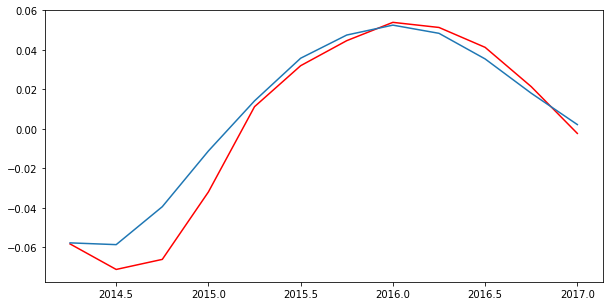

In [116]:
i_best_st, j_best_st = find_best_model(None,model, neurons_1 ,neurons_2, y_test, x_test )

In [117]:
def mean_prediction(model, neurons_1, neurons_2, x_test, y_test):
    pred = []
    for i in range(len(model)):
        for j in range(len(model[0])):
            pred.append(model[i][j].predict(x_test))
        
    mean_pred = []
    for i in range(len(pred[0])):
        res = 0
        for j in range( len(pred)):
            res += pred[j][i][0]
        mean_pred.append(res/len(pred))
    
    plt.figure(figsize(10,5))
    plt.plot(y_test.index, mean_pred, color = 'r')
    plt.plot(y_test.index, y_test.values)

    print ('Средняя ошибка = ', metrics.mean_absolute_error(y_test.values, mean_pred))
    return mean_pred

# Ошибка на среднее переобученных моделей

Средняя ошибка =  0.009041803308036873


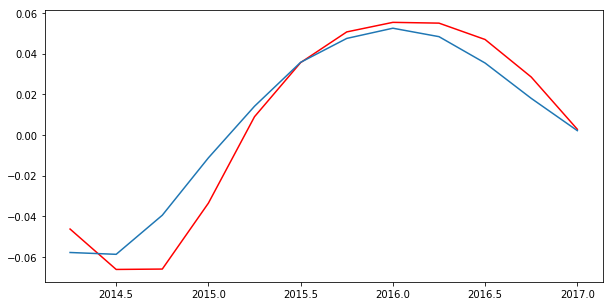

In [118]:
pred_test = mean_prediction(model, neurons_1, neurons_2, x_test, y_test)

Средняя ошибка =  0.013926505001712037


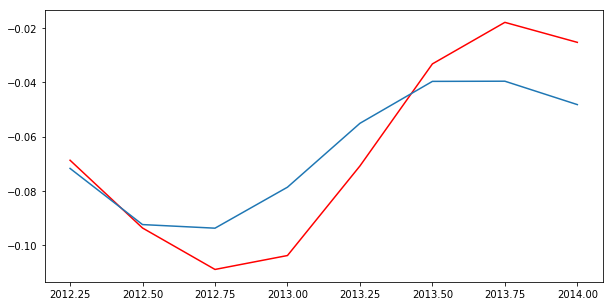

In [119]:
pred_val = mean_prediction(model, neurons_1, neurons_2, x_val, y_val)

Средняя ошибка =  0.006115114864624609


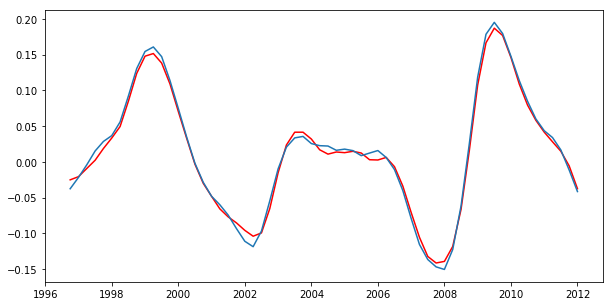

In [120]:
pred_train =mean_prediction(model, neurons_1, neurons_2, x_train, y_train)

In [121]:
all_pred = np.hstack((np.array(pred_train),np.array(pred_val), np.array(pred_test)))

In [122]:
all_y = np.hstack((np.array(y_train),np.array(y_val), np.array(y_test)))

In [123]:
all_index = np.hstack((np.array(y_train.index),np.array(y_val.index), np.array(y_test.index)))

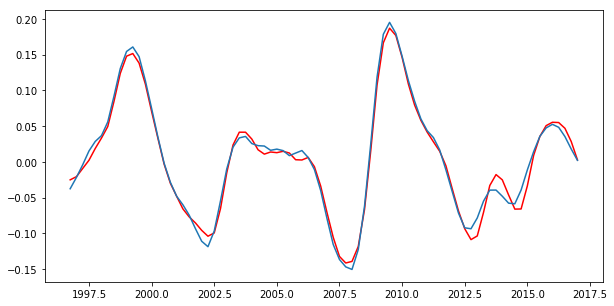

In [124]:
plt.figure(figsize(10,5))
plt.plot(all_index, all_pred, color = 'r')
plt.plot(all_index, all_y)

# Не переобученные модели

In [125]:
def load_weights(model,name_of_catalog, neurons_1, neurons_2):
    for i in range(len(neurons_1)):
        for j in range(len(neurons_2)):
            from keras.models import model_from_json
            #print("Загружаю сеть из файлов")
            # Загружаем сохраненные веса в модель
            print (i, j)
            model[i][j].load_weights(name_of_catalog+"/weights_"+str(neurons_1[i])+'_'+str(neurons_2[j])+".hdf5")
    print("Загрузка сети завершена")
    return model

In [126]:
load_model = load_weights(model,'model', neurons_1, neurons_2)

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4
Загрузка сети завершена


Средняя ошибка =  0.008937878351217565


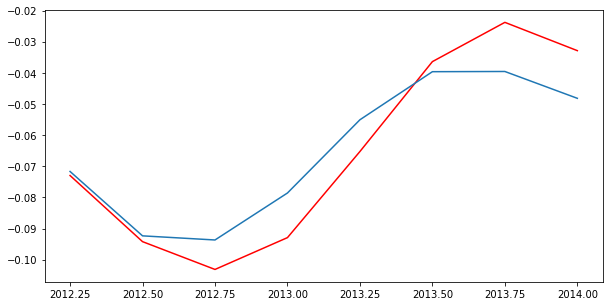

In [145]:
i_best, j_best = find_best_model(None,load_model, neurons_1 ,neurons_2, y_val, x_val )

Средняя ошибка =  0.012032308810906556


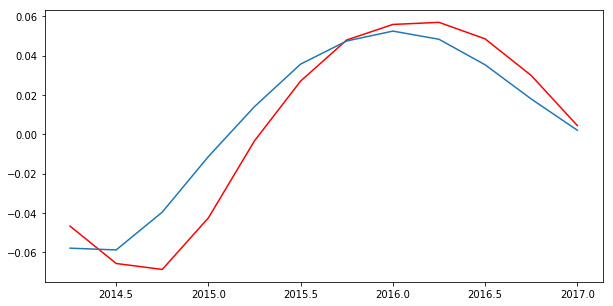

In [147]:
pred_test_best = mean_prediction(load_model, neurons_1, neurons_2, x_test, y_test)

Средняя ошибка =  0.01166728196292806


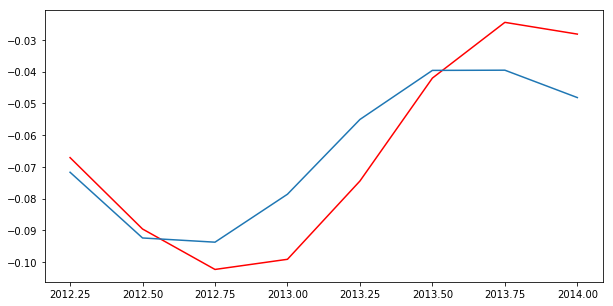

In [129]:
pred_val_best = mean_prediction(load_model, neurons_1, neurons_2, x_val, y_val)

Средняя ошибка =  0.010562921446419399


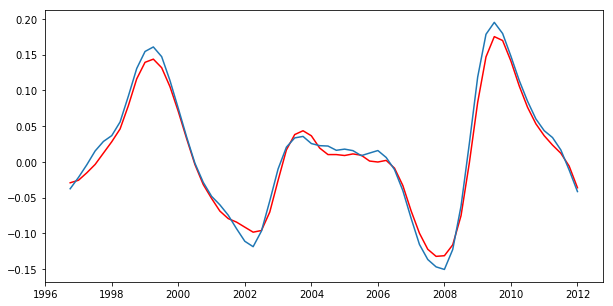

In [130]:
pred_train_best =mean_prediction(load_model, neurons_1, neurons_2, x_train, y_train)

In [131]:
# Среднее всех

In [132]:
all_pred  = []
for i in range(len(pred_test)):
    all_pred.append((pred_test[i]+pred_test_best[i])/2)

In [133]:
print ('Средняя ошибка = ', metrics.mean_absolute_error(y_test.values, all_pred))

Средняя ошибка =  0.010537056059471714


In [134]:

def all_quality(model, neurons_1, neurons_2, x_test, y_test):
    pred = []
    quality = []
    for i in range(len(model)):
        pred.append([])
        quality.append([])
        for j in range(len(model[0])):
            pred[i].append(model[i][j].predict(x_test))
            quality[i].append(metrics.mean_absolute_error(y_test.values, pred[i][j]))
    Quality = pd.DataFrame()
    for i in range(len(neurons_1)):
        Quality["neurons_"+str(neurons_1[i])] = quality[i]
    Quality.index = neurons_2
    #mean_pred = []
    #for i in range(len(pred[0])):
    #    res = 0
    #    for j in range( len(pred)):
    #        res += pred[j][i][0]
    #    mean_pred.append(res/len(pred))
    #
    #plt.figure(figsize(10,5))
    #plt.plot(y_test.index, mean_pred, color = 'r')
    #plt.plot(y_test.index, y_test.values)
    #quality = []

#    print ('Средняя ошибка = ', metrics.mean_absolute_error(y_test.values, mean_pred))
    return Quality

In [148]:
all_quality(load_model, neurons_1, neurons_2, x_val, y_val)

,neurons_5,neurons_6,neurons_7,neurons_8,neurons_9
5,0.009385,0.011853,0.010808,0.015520,0.013901
6,0.010740,0.009958,0.015655,0.013094,0.009319
7,0.010787,0.013587,0.013312,0.016141,0.016558
8,0.014408,0.008938,0.013799,0.010319,0.014988
9,0.010625,0.012732,0.013121,0.011244,0.013304


# Находим лучшую(по валидации) непереобученную модель 

Средняя ошибка =  0.008937878351217565


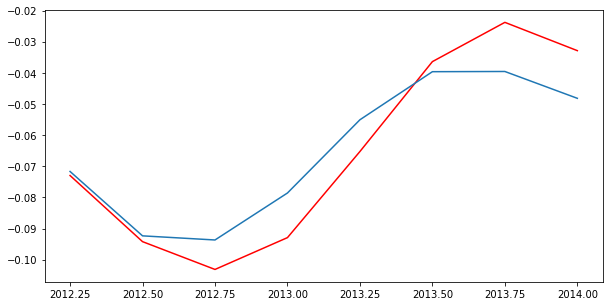

In [140]:
i_best, j_best = find_best_model(None,load_model, neurons_1 ,neurons_2, y_val, x_val )

Text(0.5,1,'6 and 8')

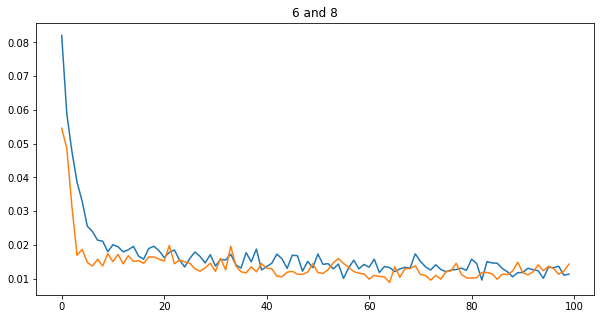

In [143]:
plt.plot(history[i_best][j_best].history['loss'])
plt.plot(history[i_best][j_best].history['val_mean_absolute_error'])
plt.title(str(neurons_1[i_best]) + " and " +str(neurons_2[j_best]))

In [203]:
pred_test = load_model[i_best][j_best].predict(x_test)
pred_val = load_model[i_best][j_best].predict(x_val)
pred_train = load_model[i_best][j_best].predict(x_train)

In [204]:
pred_val = list(pred_val.reshape((1, len(pred_val)))[0])
pred_train = list(pred_train.reshape((1, len(pred_train)))[0])
pred_test = list(pred_test.reshape((1, len(pred_test)))[0])

0.008838154707972
0.9083316930286479


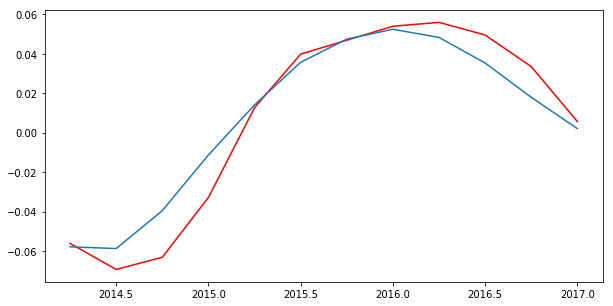

In [233]:
# Предсказания

plt.figure(figsize(10,5))
plt.plot(y_test.index, pred_test, color = 'r')
plt.plot(y_test.index, y_test.values)
print (metrics.mean_absolute_error(y_test.values,pred_test))
print (metrics.r2_score(y_test.values,pred_test))

In [207]:
all_pred = np.hstack((np.array(pred_train),np.array(pred_val), np.array(pred_test)))

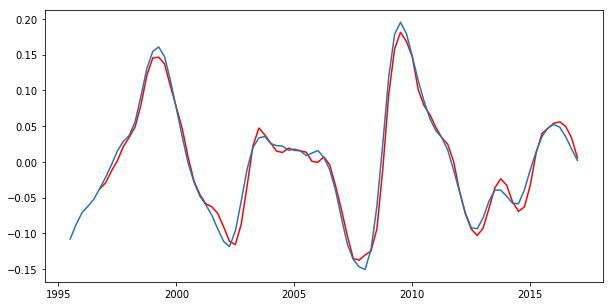

In [212]:
plt.figure(figsize(10,5))
plt.plot(lag_data.index, all_pred, color = 'r')
plt.plot(data.index, data.unemployment_cyclicity.values)
#metrics.mean_absolute_error(data.unemployment_cyclicity.values,all_pred)

In [217]:
y_val_and_train = np.hstack((np.array(y_train),np.array(y_val)))

In [218]:
y_val_and_train_index = np.hstack((np.array(y_train.index),np.array(y_val.index)))

In [216]:
pred_val_and_train = np.hstack((np.array(pred_train),np.array(pred_val)))

0.9777968051141892


0.009688091852266397

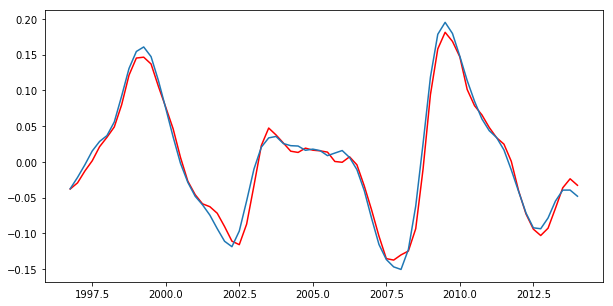

In [234]:
plt.figure(figsize(10,5))
plt.plot(y_val_and_train_index, pred_val_and_train, color = 'r')
plt.plot(y_val_and_train_index, y_val_and_train)
print (metrics.r2_score(y_val_and_train ,pred_val_and_train))
metrics.mean_absolute_error(y_val_and_train ,pred_val_and_train)

## Рассмотрим остатки этой модели

In [223]:
remnants =pd.DataFrame()
remnants['remnants'] = y_val_and_train - pred_val_and_train
remnants.index = y_val_and_train_index
remnants.head()

,remnants
1996.75,0.000377
1997.00,0.007662
1997.25,0.008722
1997.50,0.013717
1997.75,0.007353


Критерий Стьюдента: p=0.087782
Критерий Дики-Фуллера: p=0.000554


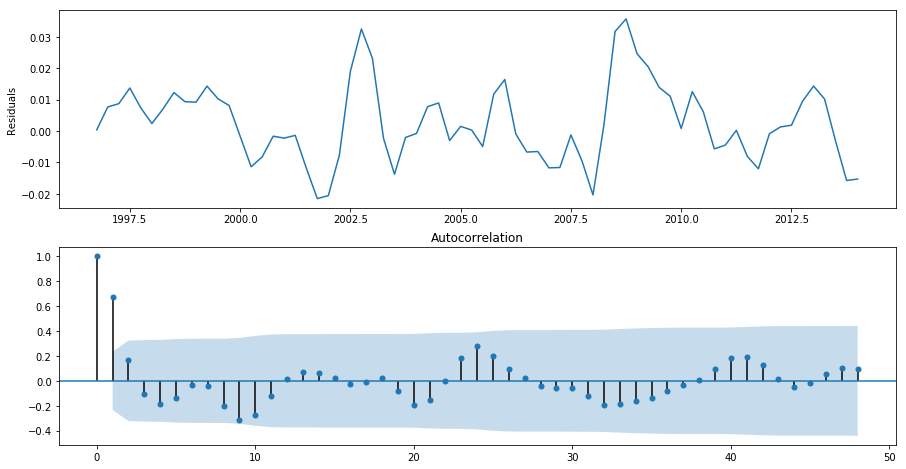

In [224]:
plt.figure(figsize(15,8))
plt.subplot(211)
plt.plot(remnants.index, remnants)
#best_model.resid[5:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(remnants, lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(remnants, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(remnants["remnants"].values)[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается коррелограммой).

In [229]:
mean_remnants = remnants.remnants.values.mean()

0.009792507106094582

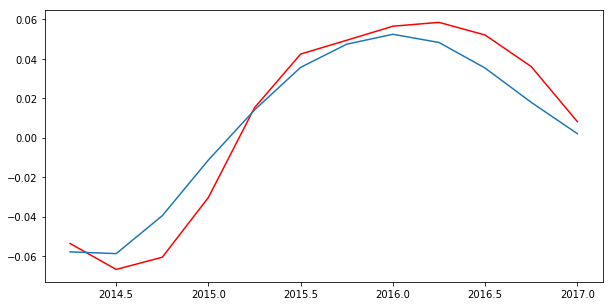

In [230]:
plt.figure(figsize(10,5))
plt.plot(y_test.index, pred_test+mean_remnants, color = 'r')
plt.plot(y_test.index, y_test.values)
metrics.mean_absolute_error(y_test.values,pred_test+mean_remnants)